In [1]:
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from utils.fairness_functions import plot_roc_curve

# Algorithmns models to be compared
from sklearn.linear_model import LogisticRegression

In [2]:
pd.set_option('display.max_columns', 100)

### Load dataset

In [3]:
df_credit = pd.read_csv("./data/german_credit_data.csv", index_col="Unnamed: 0")

## Pre-processing

### Create Age category column

In [4]:
#Let's look the Credit Amount column
interval = (18, 35, 60, 120)
cats = ['Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit['Age'], interval, labels=cats)

### Remap Job Column

In [5]:
job_map = {0: 'unskilled_&_non-resident',
           1: 'unskilled_&_resident',
           2: 'skilled',
           3: 'highly_skilled'}

# use the replace() method to remap the values
df_credit['Job'] = df_credit['Job'].replace(job_map)

### Perform one-hot-encoding

In [6]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

In [7]:
#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit['Purpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit['Sex'], prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit['Housing'], drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit['Risk'], prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
# Job to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit["Job"], drop_first=True, prefix='Job'), left_index=True, right_index=True)

### Correlation analysis

In [8]:
df_credit = df_credit.set_index('Sex')

In [9]:
df_credit = df_credit.drop(columns=['Saving accounts', 'Checking account', 'Purpose', 'Housing', 'Age_cat', 'Risk', 'Risk_good', 'Job', 'Sex_male'])

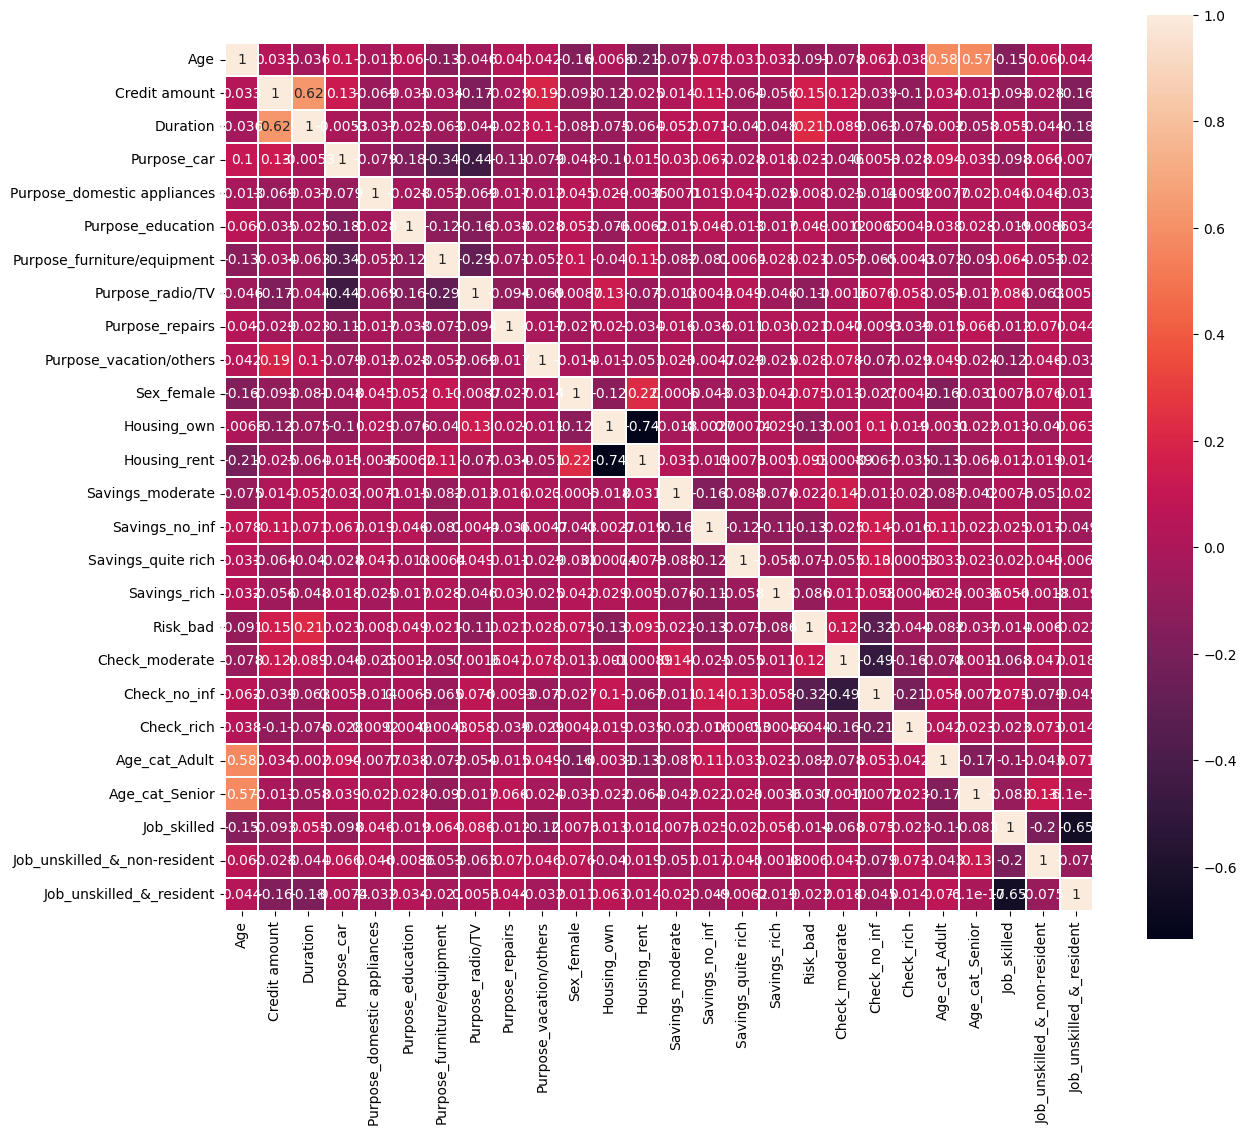

In [10]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

### Drop highly correlated sub-classes: Housing rent and own

In [11]:
df_credit = df_credit.drop(columns=['Housing_rent'])

### Split dataset (training / test)

In [12]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', axis = 1)
y = df_credit["Risk_bad"]

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Modelling - Including "protected attribute"

In [13]:
model = LogisticRegression()
model = model.fit(X_train, y_train)
y_pred_p_test = model.predict_proba(X_test)[:, 1]

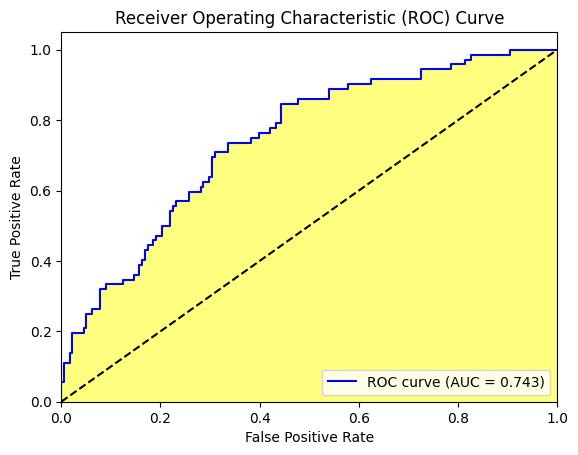

In [14]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_p_test)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)


In [15]:
# find optimal threshold based on Youden's Index
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold: ", optimal_threshold)

Optimal threshold:  0.21930892990126283


### Predict Probability of Default 

In [16]:
df_credit['Prob_default'] = model.predict_proba(X)[:, 1]
df_credit['Predicted_default'] = np.where(df_credit['Prob_default'] > optimal_threshold, 1, 0)
df_credit = df_credit.reset_index()

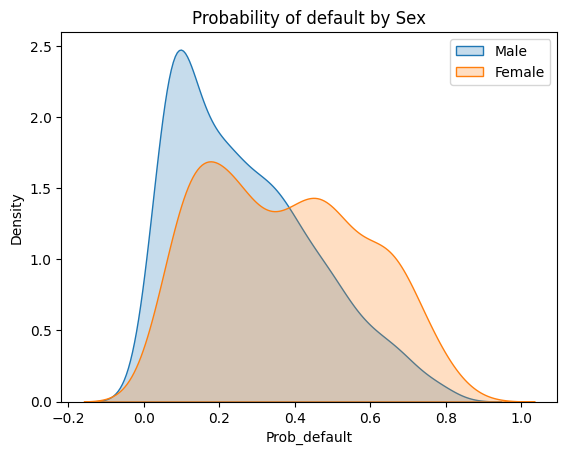

In [17]:
# plot the density plot
sns.kdeplot(df_credit.loc[df_credit['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df_credit.loc[df_credit['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')

# display the plot
plt.show()

In [18]:
df_credit = df_credit.rename(columns={'Risk_bad': 'Realised_default'})
# move 'Realised_default' column to last position
cols = list(df_credit.columns)
cols.remove('Realised_default')
cols.append('Realised_default')
df_credit = df_credit.reindex(columns=cols)

In [19]:
df_credit.head()

,Sex,Age,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_female,Housing_own,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Adult,Age_cat_Senior,Job_skilled,Job_unskilled_&_non-resident,Job_unskilled_&_resident,Prob_default,Predicted_default,Realised_default
0,male,67,1169,6,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0.070398,0,0
1,female,22,5951,48,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0.680953,1,1
2,male,49,2096,12,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0.066914,0,0
3,male,45,7882,42,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.612084,1,0
4,male,53,4870,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.470040,1,1


In [20]:
model_output = df_credit[['Sex', 'Prob_default', 'Predicted_default', 'Realised_default']]

In [21]:
model_output.to_csv("./data/model_output_biased.csv", index=False)

## Modelling - Excluding "protected attribute"

In [22]:
X = X.drop('Sex_female', axis=1)
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [23]:
model = LogisticRegression()
model = model.fit(X_train, y_train)
y_pred_p_test = model.predict_proba(X_test)[:, 1]

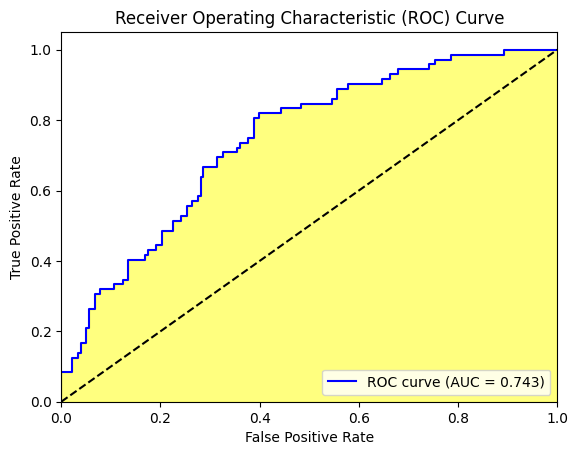

In [24]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_p_test)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)


In [25]:
# find optimal threshold based on Youden's Index
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold: ", optimal_threshold)

Optimal threshold:  0.23557834069300093


### Predict Probability of Default 

In [26]:
df_credit['Prob_default'] = model.predict_proba(X)[:, 1]
df_credit['Predicted_default'] = np.where(df_credit['Prob_default'] > optimal_threshold, 1, 0)
df_credit = df_credit.reset_index()

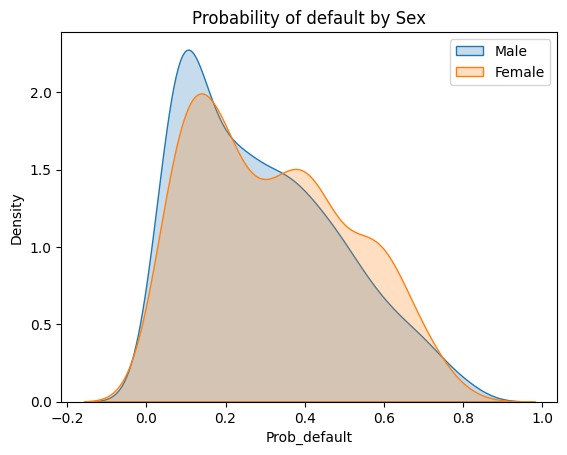

In [27]:
# plot the density plot
sns.kdeplot(df_credit.loc[df_credit['Sex']=='male', 'Prob_default'], shade=True, label='Male')
sns.kdeplot(df_credit.loc[df_credit['Sex']=='female', 'Prob_default'], shade=True, label='Female')

# add legend and title
plt.legend()
plt.title('Probability of default by Sex')

# display the plot
plt.show()

In [28]:
df_credit = df_credit.rename(columns={'Risk_bad': 'Realised_default'})
# move 'Realised_default' column to last position
cols = list(df_credit.columns)
cols.remove('Realised_default')
cols.append('Realised_default')
df_credit = df_credit.reindex(columns=cols)

In [29]:
df_credit.head()

,index,Sex,Age,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_female,Housing_own,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Adult,Age_cat_Senior,Job_skilled,Job_unskilled_&_non-resident,Job_unskilled_&_resident,Prob_default,Predicted_default,Realised_default
0,0,male,67,1169,6,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0.085109,0,0
1,1,female,22,5951,48,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0.621278,1,1
2,2,male,49,2096,12,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0.072370,0,0
3,3,male,45,7882,42,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.650876,1,0
4,4,male,53,4870,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.506724,1,1


In [30]:
model_output = df_credit[['Sex', 'Prob_default', 'Predicted_default', 'Realised_default']]

In [31]:
model_output.to_csv("./data/model_output_unbiased.csv", index=False)